# Snakemake版本的HiCPro构建

In [1]:
import glob
import json

## 参数设置

In [2]:
thread = 20

bowtie2_index
```shell
bowtie2-build -f genome_ucsc_mm39.fa genome_ucsc_mm39.fa.bowtie2_index --threads 24
```

chromosome_size
```shell
# hg38
samtools faidx genome_ucsc_hg38.fa
cut -f1-2 genome_ucsc_hg38.fa.fai > chrom_hg38.sizes

# mm39
samtools faidx genome_ucsc_mm39.fa
cut -f1-2 genome_ucsc_mm39.fa.fai > chrom_mm39.sizes

# digest
program/HiC-Pro_3.1.0/bin/utils/digest_genome.py -r dpnii -o DpnII_resfrag_hg38.bed genome_ucsc_hg38.fa

program/HiC-Pro_3.1.0/bin/utils/digest_genome.py -r dpnii -o DpnII_resfrag_hg38.bed ~/1.database/db_genomes/genome_fa/genome_ucsc_hg38/genome_ucsc_hg38.fa 


# DpnII的说明
<!-- ![](https://p.ipic.vip/vw0ufc.jpg) -->
```



In [3]:
# 内置了mboi, dpnii, bglii, hindiii四种酶的位点, 如果是其他位点, 可以在命令行指定

# hg38
genome_index = "/lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/genome_fa/genome_ucsc_hg38/genome_ucsc_hg38.fa.fai"
bowtie2_index = "/lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/genome_fa/genome_ucsc_hg38/genome_ucsc_hg38.fa.bowtie2_index"
chr_sizes = "program/HiC-Pro_3.1.0/annotation/chrom_hg38.sizes"

# mm39
# genome_index = "/lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/genome_fa/genome_ucsc_mm39/genome_ucsc_mm39.fa.fai"
# bowtie2_index = "/lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/genome_fa/genome_ucsc_mm39/genome_ucsc_mm39.fa.bowtie2_index"
# chr_sizes = "program/HiC-Pro_3.1.0/annotation/chrom_mm39.sizes"

In [4]:
# bowtie2 options for mapping step1.
# 比对时采用--reorder参数，确保以fastq完全相同的顺序输出sam文件
# Default:
#     "--very-sensitive -L 30 --score-min L,-0.6,-0.2 --end-to-end --reorder"

bowtie2_params_global = (
    "--very-sensitive -L 30 --score-min L,-0.6,-0.2 --end-to-end --reorder"
)

In [5]:
# bowtie2 options for mapping step2.
# 比对时采用--reorder参数，确保以fastq完全相同的顺序输出sam文件
# Default:
#     "--very-sensitive -L 20 --score-min L,-0.6,-0.2 --end-to-end --reorder"

bowtie2_params_local = (
    "--very-sensitive -L 20 --score-min L,-0.6,-0.2 --end-to-end --reorder"
)

# 采用部分比对参数(--local)，以代替端到端比对(--end-to-end), 因为HiC是嵌合片段，因此使用部分比对提高比对效率
# 但是这里仍然要采用endtoend模式
# 原因详见 https://groups.google.com/g/hic-pro/c/2K43gMov7FI
# 这里还叫local是历史原因

In [6]:
# 如果KR不好用考虑删除？！

# used for hicexplorer!

# [restriction site sequence]
# HindIII 
# the restriction site is AAGCTT and the dangling end is AGCT. 
# restriction_sequence = "AAGCTT"  # HindIII
# dangling_sequence = "AGCT"  # HindIII

# For DpnII, the restriction site and dangling end sequence are the same: GATC. 
# This information is easily found on the description of the restriction enzyme.
restriction_sequence = "GATC"  # DpnII
dangling_sequence = "GATC"  # DpnII

In [7]:
# samtools sort
#   -m INT     Set maximum memory per thread; suffix K/M/G recognized [768M]
# sort_ram_per_thread = "" # use default setting of samtools sort
sort_ram_per_thread = ""
# sort_ram_per_thread = "-m 500M"

In [8]:
# form_pairs_bam in HiC-Pro
# mergeSAM.py
# Minimum mapping quality. Reads with lower quality are discarded. Default: 0
min_mapq = 10

In [9]:
# form matrix of different bin size
# #######################################################################
# ## Contact Maps
# #######################################################################
# Resolution of contact maps to generate
# Default: 20_000 40_000 150_000 500_000 1_000_000
#
# For compartment: 10mb~100mb
# For TAD: 100kb~10mb
# For functional loops: 10kb~100kb
# For nucleosome clutches: 1kb~2kb

# 这几个就行
# 10_000,
# 50_000,
# 100_000,
# 200_000,
# 500_000,
# 1_000_000,
#######################################################################
bin_sizes = [
    # For nucleosome clutches: 1kb~2kb
    # 1_000,
    # 2_000,
    # 5_000,
    # For functional loops: 10kb~100kb
    10_000,
    # 20_000,
    50_000,
    100_000,
    # For TAD: 100kb~10mb
    200_000,
    500_000,
    1_000_000,
    # For compartment: 10mb~100mb
    # 10_000_000,
    # 50_000_000,
    # 100_000_000,
]
# Output matrix format. 
# Must be complete, asis, upper or lower. 
# Default: upper
matrix_format = "upper"

In [10]:
# #######################################################################
# ## Digestion Hi-C
# #######################################################################
# ------------------------------------>
# GENOME_FRAGMENT:
# ------------------------------------>
# digest_bed = "program/HiC-Pro_3.1.0/annotation/HindIII_resfrag_hg38.bed"
digest_bed = "program/HiC-Pro_3.1.0/annotation/DpnII_resfrag_hg38.bed"
# digest_bed = "program/HiC-Pro_3.1.0/annotation/HindIII_resfrag_mm39.bed"
# ------------------------------------>





# ------------------------------------>
# LIGATION_SITE
# ------------------------------------>
# used for reads trimming in HiC-Pro
# HindIII
# ligation_site = "AAGCTAGCTT"  # from test-op/config_test_latest.txt
# DpnII
ligation_site = "GATCGATC"  # from test-op/config_test_latest.txt
# https://github.com/nservant/HiC-Pro/issues/324
# https://groups.google.com/g/hic-pro/c/fFdY2QqEtcc
# DpnII's cut site is  5'--- ^GATC ---3' 
# 在这里，HiC-Pro 期待的是 LIGATION 基序，而不是 RESTRICTION 基序。
# 所以，如果是 DpnII 酶，它应该是GATCGATC
# ------------------------------------>




# ------------------------------------>
# Fragment and Insert size and Hi-C processing
# ------------------------------------>
# MIN_FRAG_SIZE
# MAX_FRAG_SIZE
# MIN_INSERT_SIZE
# MAX_INSERT_SIZE
# https://groups.google.com/g/hic-pro/c/HT3eBcb9yqQ/m/WkzIrASbAgAJ
min_frag_size = 100
max_frag_size = 100000
min_insert_size = 100
max_insert_size = 800
min_cis_dist = 1
# ------------------------------------>

In [11]:
# #######################################################################
# ## ICE Normalization
# #######################################################################
# MAX_ITER = 100
# FILTER_LOW_COUNT_PERC = 0.02
# FILTER_HIGH_COUNT_PERC = 0
# EPS = 0.1

## 生成samples.json

In [12]:
ls = glob.glob("../fastq/*.fastq.gz")
ls.sort()
assert ls != []  # 需要非空
# 默认 HiC是双端测序
ls_pe = [i for i in ls if i.endswith("R1.fastq.gz")]

if ls_pe:
    ls_sample = [i.split("/")[-1].split("_R1.fastq")[0] for i in ls_pe]
    end_type = "PE"
ls_sample

['293T_HiC_DddA11.DdCBE_JAK2_rep1',
 '293T_HiC_DddA11.DdCBE_SIRT6_rep1',
 '293T_HiC_DddA11.Dead.DdCBE_SIRT6_rep1',
 '293T_HiC_DddAwt.DdCBE_ND6_rep1',
 '293T_HiC_DddAwt.DdCBE_ND6_rep2',
 '293T_HiC_GFP_rep1',
 '293T_HiC_GFP_rep2',
 '293T_HiC_GFP_rep3',
 '293T_HiC_Nature2022.Fig4-WT',
 'SRR400264_00',
 'SRR400264_01',
 'test']

In [13]:
# for test and select
ls_sample = [
    '293T_HiC_DddA11.DdCBE_JAK2_rep1',
    '293T_HiC_DddA11.DdCBE_SIRT6_rep1',
    '293T_HiC_DddA11.Dead.DdCBE_SIRT6_rep1',
    '293T_HiC_DddAwt.DdCBE_ND6_rep1',
    '293T_HiC_DddAwt.DdCBE_ND6_rep2',
    '293T_HiC_GFP_rep1',
    '293T_HiC_GFP_rep2',
    '293T_HiC_GFP_rep3',
    '293T_HiC_Nature2022.Fig4-WT',
    "SRR400264_00",  # for test
    "SRR400264_01",  # for test
    "test",
]

In [14]:
dt = {
    "seq_mode": end_type,
    "samples": ls_sample,
    "thread": thread,
    "genome_index": genome_index,
    "bowtie2_index": bowtie2_index,
    "bowtie2_params_global": bowtie2_params_global,
    "bowtie2_params_local": bowtie2_params_local,
    "ligation_site": ligation_site,
    "sort_ram_per_thread": sort_ram_per_thread,
    "min_mapq": min_mapq,
    "bin_sizes": bin_sizes,
    "chr_sizes": chr_sizes,
    "digest_bed": digest_bed,
    "restriction_sequence": restriction_sequence,
    "dangling_sequence": dangling_sequence,
    "min_frag_size": min_frag_size,
    "max_frag_size": max_frag_size,
    "min_insert_size": min_insert_size,
    "max_insert_size": max_insert_size,
    "min_cis_dist": min_cis_dist,
    "matrix_format": matrix_format,
}
dt

{'seq_mode': 'PE',
 'samples': ['293T_HiC_DddA11.DdCBE_JAK2_rep1',
  '293T_HiC_DddA11.DdCBE_SIRT6_rep1',
  '293T_HiC_DddA11.Dead.DdCBE_SIRT6_rep1',
  '293T_HiC_DddAwt.DdCBE_ND6_rep1',
  '293T_HiC_DddAwt.DdCBE_ND6_rep2',
  '293T_HiC_GFP_rep1',
  '293T_HiC_GFP_rep2',
  '293T_HiC_GFP_rep3',
  '293T_HiC_Nature2022.Fig4-WT',
  'SRR400264_00',
  'SRR400264_01',
  'test'],
 'thread': 20,
 'genome_index': '/lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/genome_fa/genome_ucsc_hg38/genome_ucsc_hg38.fa.fai',
 'bowtie2_index': '/lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/genome_fa/genome_ucsc_hg38/genome_ucsc_hg38.fa.bowtie2_index',
 'bowtie2_params_global': '--very-sensitive -L 30 --score-min L,-0.6,-0.2 --end-to-end --reorder',
 'bowtie2_params_local': '--very-sensitive -L 20 --score-min L,-0.6,-0.2 --end-to-end --reorder',
 'ligation_site': 'GATCGATC',
 'sort_ram_per_thread': '',
 'min_mapq': 10,
 'bin_sizes': [10000, 50000, 100000, 200000, 500000, 1000000],
 'chr_sizes': 'pro

In [15]:
with open("./samples.json", "wt") as f:
    f.write(json.dumps(dt))

# Hi-C原理简介

- Hi-C技术高通量染色体构象捕获技术(High-throughput chromosome conformation capture)研究全基因组三维构象及分析染色质片段相互作用的实验技术
- Hi-C目的了解核内染色质的三维构象、获得细胞核内空间位置非常接近或存在相互作用的染色质测序片段更好地研究染色质内或染色质间的互作、基因调控元件在全基因组范围内调控的情况
- Hi-C应用方向辅助基因组组装、揭示空间调控、揭示物种进化、疾病研究、三维结构差异分析、还原染色体三维结构、构建染色体跨度单体型
- 互作本质统计学上基因组两点之间发生空间接触的概率
- Hi-C实验原理

    ![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywfnuz6yj20jg09f759.jpg)

- 二代文库构建及测序二代文库进行片段筛选400-600bp的片段，实际插入片段长度为300-500bp一般测序读长：PE150 

    ![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywglepvij20jg0abt98.jpg)

- Hi-C实际文库类型将HIC数据进行比对是会出现不同的比对情况，我们需要的是双端唯一匹配。对单端匹配、多处比对、未比对的reads进行过滤。 

    ![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywh5s97mj20jg07q74b.jpg)
- 对Hi-C文库构建中产生的多种分子类型，包括 re-ligation、Dangling ends、self circle 、dump reads 及valid pairs reads等类型。 在 Hi-C 分析中，仅valid pair可以反映基因组上位点与位点间的互作信息。因此，非重复的valid pair所占的比例是评估Hi-C文库质量的 重要指标 

    ![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywhfz9gij20jg0ait94.jpg)
- 互作矩阵的生成由于计算资源，数据量等因素，我们往往认为确定一个互作单位：bin。将基因组按照一定大小分成bin。将过滤后的有效序列分配到这些bin中 

    ![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywhqu028j2099046mx3.jpg)
- 互作矩阵的矫正Hi-C数据中由于内切酶的偏好性、基因组本身质量、基因组序列特异性会导致其在基因组不同位置间存在偏差。因此，我们会对互作矩阵进行校正，使其数据在基因组上每个位点的覆盖度一致。常用的矫正方式有迭代矫正、归一化等 

    ![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywhztfp2j20jg07pjrt.jpg)

# 常用短序列比对软件

![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywjka2v3j20l809swfb.jpg)

# SAM格式

![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywk0xx5wj20lm0kqmz7.jpg)

# HiC常规软件比较

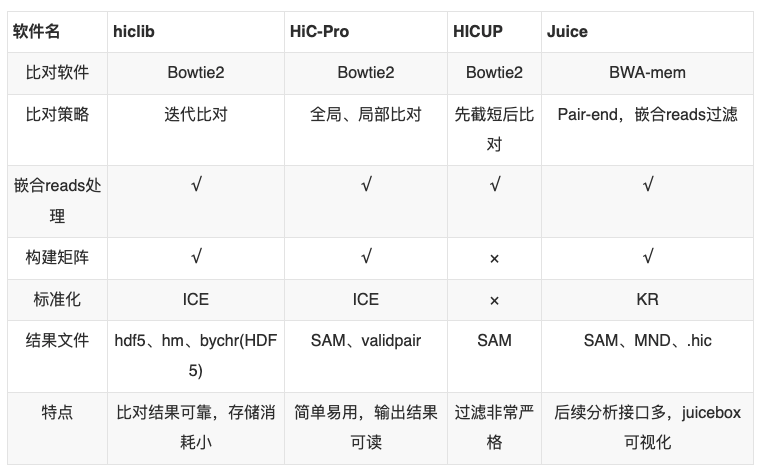

# HiC-Pro配置环境
从官方GitHub仓库中clone下来仓库，然后
使用HiC-Pro中的yml文件创建conda环境
```
mamba env create -f environment.yml
```
激活环境
```
conda activate HiC-Pro_v3.1.0
# environment.yml 中已经预先指定了biopython=1.72
mamba install hicexplorer
```

读一下HiC-Pro的github官方仓库，按照github readme文件make configure和make install将HiC-Pro配置好

# HiC-Pro工作流程学习

> 原始文献
> https://genomebiology.biomedcentral.com/articles/10.1186/s13059-015-0831-x

## HiC-Pro Pipeline
![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywp97jrbj20fr0jqq45.jpg)

红色方框标记的是数据预处理部分，功能和HICUP软件类似，包括:

- 序列比对;
- 筛选valid pairs;
- 预处理之后就是binning, 构建不同分辨率下的原始的交互矩阵contact map;
- 最后对原始的contact map进行归一化处理，得到校正后的contact map.

HiC-Pro的一个强大功能在于可以构建单倍型级别的Hi-C图谱，单倍型级别的Hi-C图谱有助于更加精细化理解基因组三维结构，进一步对基因调控等功能进行深入细致的研究。

整个处理过程分为以下几个步骤:

### 序列比对

HiC-Pro采用了两步比对的策略，如下所示

![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywpplc8ej20hm0fl0td.jpg)

- 考虑到连接点在插入片段上的位置和测序读长的关系，第一步先将R1和R2端**分别与基因组比对**;
- 对于没有比对上的reads, 可能是存在连接点的嵌合体reads, 也可能本身就是unmapping reads;
- 通过从3’端切除部分序列的方式，使得嵌合体序列也能够比对上基因组， 两步策略保证了数据的利用率.

### 筛选valid pairs

比对时将R1和R2端分开单独考虑，但是二者其实来自于同一个fragment, 这一步的筛选其实是能够代表染色质交互的有效fragment，**这样的fragment肯定是一个嵌合体序列，有来自交互作用的两个染色质区域的序列构成**， 如下图所示

![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywqg1khjj20gl091aai.jpg)

只有来自嵌合体fragment的reads才被定义为valid  pairs, 然后进行后续分析。


### 构建原始HiC图谱

根据指定的分辨率，统计两个bin区域内valid  pairs的数目, 去除PCR重复之后，构建原始的交互矩阵。

### 归一化

不同区域GC含量，mapping概率等系统误差都使得原始的交互矩阵不能够有效代表染色质交互信息， 所以需要进行归一化。采用了一种迭代校正的归一化算法对原始的交互矩阵进行归一化，矫正系统误差。

HIC-Pro还提供了一系列的质控标准，如下图所示

![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywqro32oj20gy0cuwfc.jpg)

一个高质量的文库绝大部分肯定都能够比对上基因组，如图A所示， R1和R2的比对率都很高。
而比对上的reads中应该主要是unique mapping, 如图A第二张图所示，multiple hits和low  quality也是文库质量的指标之一。

**valid pairs的比例则是文库质量的最直接体现，valid  pairs的比例至少要在50%以上。**

将染色质交互作用进一步区分为**染色质之间的inter-interaction 对应B图中的trans contact**, 和**染色质内部的intra-interaction, 对应cis contact**。
**对于cis contact, 根据距离阈值分成short和long两种**。

**一个高质量的文库首先intra-interaction的比例在40%以上**，其次由于**线性距离近的染色质更容易随机结合，引入系统误差**，所以**高质量文库的cis long contacts的比例在40%以上**。

HiC-Pro所有的参数都放置在一个配置文件中，既可以一键化运行整个pipeline, 也可以分布运行，单独执行其中的某几步，灵活性很强.


# 构建酶切图谱和染色体畅读文件
## 酶切图谱构建

![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywrkcnx4j20la0fmt9t.jpg)

```
python /lustre1/chengqiyi_pkuhpc/zhaohn/0.apps/HiC-Pro_installed/HiC-Pro_3.1.0/bin/utils/digest_genome.py \
    -r hindiii \
    -o hg38_hindiii.bed \
    /lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/genome_fa/genome_ucsc_hg38/genome_ucsc_hg38.fa
```

## 染色体长度构建
fasta的fai文件中的前两列信息就是长度

![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywrv1j60j20lo0abdge.jpg)

```
samtools faidx /lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/genome_fa/genome_ucsc_hg38/genome_ucsc_hg38.fa

cut -f1-2 /lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/genome_fa/genome_ucsc_hg38/genome_ucsc_hg38.fa.fai > chrom_hg38.sizes
```

## 选用测试文件进行测试和练习
```
wget  https://zerkalo.curie.fr/partage/HiC-Pro/HiCPro_testdata.tar.gz && tar -zxvf HiCPro_testdata.tar.gz
```

# HiC-Pro的config file示例和标注
## 完整版config，copy粘贴就可以用
```shell
# Copy and edit the configuration file ‘config-hicpro.txt’ in your local folder. 
# 
# The ‘[]’ options are optional and can be undefined.
# 带有[]中括号的参数可以不定义，为可选参数
# Please change the variable settings below if necessary
#########################################################################
## Paths and Settings  - Do not edit !
## 输入输出文件路径，尽量不动
#########################################################################
TMP_DIR = tmp

LOGS_DIR = logs

BOWTIE2_OUTPUT_DIR = bowtie_results

MAPC_OUTPUT = hic_results

# Link to rawdata folder. The user usually not need to change this option
# 尽量不该rawdata路径
RAW_DIR = rawdata

#######################################################################
## SYSTEM AND SCHEDULER - Start Editing Here !!
## 从这里开始编辑
#######################################################################
# ?文档中没有说明
SORT_RAM = 1000M

# name of the main log file
LOGFILE = hicpro.log

# 【可选参数】name of the job on the cluster
JOB_NAME = ZHN-HiC 

# 【可选参数】队列指定
JOB_ACCOUNT = chengqiyi_g1
# 【cnlong】
# N_CPU = 20
# JOB_QUEUE = cn-long
# JOB_QOS = chengqiyicnl

# 【cn-short】
# N_CPU = 20
# JOB_QUEUE = cn-short
# JOB_QOS = chengqiyicns

# 【cn_nl】
N_CPU = 20
JOB_QUEUE = cn_nl
JOB_QOS = chengqiyicnnl

# 【fat4way】
# N_CPU = 24
# JOB_QUEUE = fat4way
# JOB_QOS = chengqiyif4w

# 【fat8way】
# N_CPU = 64
# JOB_QUEUE = fat8way
# JOB_QOS = chengqiyif8w
#########################################################################
## Data
#########################################################################
# Keyword for first mate detection. Default:_R1
PAIR1_EXT = _R1

# Keywoard for seconde mate detection. Default:_R2
PAIR2_EXT = _R2

#######################################################################
## Alignment options
#######################################################################
# Minimum mapping quality. 
# Reads with lower quality are discarded. 
# Default: 0
MIN_MAPQ = 10

# Path to bowtie2 indexes
BOWTIE2_IDX_PATH = /lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/genome_fa/genome_ucsc_hg38/

# bowtie2 options for mapping step1. 
# Default: –very-sensitive -L 30 –score-min L,-0.6,-0.2 –end-to-end –reorder
BOWTIE2_GLOBAL_OPTIONS = --very-sensitive -L 30 --score-min L,-0.6,-0.2 --end-to-end --reorder

# bowtie2 options for mapping step2. 
# Default: –very-sensitive -L 20 –score-min L,-0.6,-0.2 –end-to-end –reorder
BOWTIE2_LOCAL_OPTIONS =  --very-sensitive -L 20 --score-min L,-0.6,-0.2 --end-to-end --reorder

#######################################################################
## Annotation files
#######################################################################
# Reference genome prefix used for genome indexes. 
# Default: hg19
# 【需要升级为hg38，查阅文档】
REFERENCE_GENOME = genome_ucsc_hg38.fa.bowtie2_index

# Chromsome size file. 
# Loaded from the ANNOTATION folder in the HiC-Pro installation directory. 
# Default: chrom_hg19.sizes
# 这个要放到安装文件夹下头！
# 【需要升级为hg38，查阅文档】
GENOME_SIZE = chrom_hg38.sizes

#######################################################################
## Allele specific analysis
## http://nservant.github.io/HiC-Pro/AS.html#as
#######################################################################
# VCF file to SNPs which can be used to distinguish parental origin. See the allele specific section for more details
# 【可选参数】
# ALLELE_SPECIFIC_SNP = 

#######################################################################
## Capture Hi-C analysis
#######################################################################
# BED file of target regions to focus on (mainly used for capture Hi-C data
# 【可选参数】
# CAPTURE_TARGET =
REPORT_CAPTURE_REPORTER = 1

#######################################################################
## Digestion Hi-C
#######################################################################
# BED file with restriction fragments. 
# Full path or name of file available in the ANNOTATION folder. 
# Default: HindIII_resfrag_hg19.bed
# 含有限制性片段的BED文件
# 这个要放到安装文件夹下头！
# 【需要升级为hg38，查阅文档】
GENOME_FRAGMENT = HindIII_resfrag_hg38.bed

# Ligation site sequence used for reads trimming. 
# Depends on the fill in strategy. 
# Example: AAGCTAGCTT
# 酶的序列，例如：
# HindIII，为AAGCTAGCTT
# MboI，为GATCGATC
LIGATION_SITE = AAGCTAGCTT

# Minimum size of restriction fragments to consider for the Hi-C processing.
# Example: 100
# 为Hi-C处理考虑的限制片段的【最小大小】
MIN_FRAG_SIZE = 100

# Maximum size of restriction fragments to consider for the Hi-C processing.
# Example: 100000
# # 为Hi-C处理考虑的限制片段的【最大大小】
MAX_FRAG_SIZE = 100000

# Minimum sequenced insert size. 
# Shorter 3C products are discarded. 
# Example: 100
# 测得【最小】插入大小。
# 较短的3C产物会被丢弃
MIN_INSERT_SIZE = 100

# Maximum sequenced insert size. 
# Larger 3C products are discarded. 
# Example: 600
# 测得【最大】插入大小。
# 较短的3C产物会被丢弃
MAX_INSERT_SIZE = 600

#######################################################################
## Hi-C processing
#######################################################################
# Filter short range contact below the specified distance. 
# Mainly useful for DNase Hi-C. 
# Example: 1000
MIN_CIS_DIST =

# Create output files with all classes of 3C products. 
# Default: 0
GET_ALL_INTERACTION_CLASSES = 1

# Create a BAM file with all aligned reads flagged according to 
# their classifaction and mapping category. 
# 是否保留BAM文件，默认不保留
# Default: 0
GET_PROCESS_SAM = 1

# Remove singleton reads. 
# Default: 1
RM_SINGLETON = 1

# Remove multi-mapped reads. 
# Default: 1
RM_MULTI = 1

# Remove duplicated reads’ pairs. 
# Default: 1
RM_DUP = 1

#######################################################################
## Contact Maps
#######################################################################
# Resolution of contact maps to generate (space separated). 
# Default: 20000 40000 150000 500000 1000000
BIN_SIZE = 20000 40000 150000 500000 1000000

# Binning step size in ‘n’ coverage _i.e._ window step. 
# Default: 1
# BIN_STEP

# Output matrix format. 
# Must be complete, asis, upper or lower. 
# Default: upper
MATRIX_FORMAT = upper

#######################################################################
## Normalization
#######################################################################
# Maximum number of iteration for ICE normalization. 
# Default: 100
MAX_ITER = 100

# Define which pourcentage of bins with low counts should be force to zero. 
# Default: 0.02. 
# Replace SPARSE_FILTERING
FILTER_LOW_COUNT_PERC = 0.02

# Define which pourcentage of bins with low counts should be discarded 
# before normalization. 
# Default: 0
FILTER_HIGH_COUNT_PERC = 0

# The relative increment in the results before declaring convergence. 
# Default: 0.1
EPS = 0.1

```

## 关键参数注释
N_CPU:给定的CPU内存数，给的越多，运行的越快（根据服务器配置）；

LOGFILE:日志文件的名称；

JOB_MEM:内存的大小

PAIR1_EXT= _R1 :R1测序数据名称中有_R1

PAIR2_EXT = _R2:R2测序数据名称中有_R2

MIN_MAPQ: 最低的质量分数，用于筛选，表示低于该MAPQ值会被过滤

BOWTIE2_IDX_PATH: 基因组bowtie2索引路径，eg:/path/hg19

BOWTIE2_GLOBAL_OPTIONS: 默认GLOBAL比对设置

BOWTIE2_LOCAL_OPTIONS: 默认LOCAL比对设置

REFERENCE_GENOME： Bowtie2索引前缀

GENOME_SIZE： 基因组sizes bed文件

GENOME_FRAGMENT: 基因组酶切文件,eg. /path/hg19_HindIII.bed

LIGATION_SITE: 酶切位点末端补平再次连接后形成的嵌合序列，eg. AAGCTAGCTT

MIN_FRAG_SIZE: 最小的理论酶切片段大小,eg. 100

MAX_FRAG_SIZE: 最大的理论酶切片段大小,eg. 100000

MIN_INSERT_SIZE: 最小的文库片段大小,eg.100

MAX_INSERT_SIZE: 最大的文库片段大小,eg.1000

BIN_SIZE:需要生成的矩阵分辨率（bp)

MATRIX_FORMAT：矩阵的形式，upper表示保留上半部分

# 北极星SLurm集群特殊改动
## HiC-Pro安装目录修改
### script下的make_slurm_script.sh需要修改

【直接复制】

```shell
#!/bin/bash

## HiC-Pro
## Copyright (c) 2015 Institut Curie                               
## Author(s): Nicolas Servant
## Contact: nicolas.servant@curie.fr
## This software is distributed without any guarantee under the terms of the BSD-3 licence.
## See the LICENCE file for details

##
## Create SLURM Torque files
##

dir=$(dirname $0)

usage()
{
    echo "usage: $0 -c CONFIG [-s STEP]"
}

MAKE_OPTS=""

while [ $# -gt 0 ]
do
    case "$1" in
    (-c) conf_file=$2; shift;;
	(-s) MAKE_OPTS=$2; shift;;
    (--) shift; break;;
    (-*) echo "$0: error - unrecognized option $1" 1>&2; exit 1;;
    (*)  suffix=$1; break;;
    esac
    shift
done

if [ -z "$conf_file" ]; then usage; exit 1; fi

CONF=$conf_file . $dir/hic.inc.sh
unset FASTQFILE

## Define input files
if [[ $MAKE_OPTS == "" || $MAKE_OPTS == *"mapping"* ]]
then
    inputfile=inputfiles_${JOB_NAME}.txt
    ifq=$(get_hic_files $RAW_DIR .fq)
    ifastq=$(get_hic_files $RAW_DIR .fastq)
    echo -e "$ifq\n$ifastq" | grep $PAIR1_EXT | sed -e "s|$RAW_DIR||" -e "s|^/||" > $inputfile
    count=$(cat $inputfile | wc -l)
elif [[ $MAKE_OPTS == *"proc_hic"* ]]
then
    inputfile=inputfiles_${JOB_NAME}.txt
    get_hic_files $RAW_DIR .bam | grep $PAIR1_EXT | sed -e "s|$RAW_DIR||" -e "s|^/||" > $inputfile
    count=$(cat $inputfile | wc -l)
fi

## Paralelle Implementation
if [[ $MAKE_OPTS == "" || $MAKE_OPTS == *"mapping"* || $MAKE_OPTS == *"proc_hic"* ]]
then
    make_target="all_sub"
    ## Remove per sample steps
    if [[ $MAKE_OPTS != "" ]]; then 
    make_target=$(echo $MAKE_OPTS | sed -e 's/,/ /g'); 
    make_target=$(echo $make_target | sed -e 's/merge_persample//g');
    make_target=$(echo $make_target | sed -e 's/build_contact_maps//g');
    make_target=$(echo $make_target | sed -e 's/ice_norm//g');
        make_target=$(echo $make_target | sed -e 's/quality_checks//g');
    fi
 
    ## step 1 - parallel
    torque_script=HiCPro_step1_${JOB_NAME}.sh
 
    cat > ${torque_script} <<EOF
#!/bin/bash
#SBATCH -N 1
#SBATCH -c ${N_CPU}
#SBATCH -p ${JOB_QUEUE}

#SBATCH --job-name=s1_${JOB_NAME}_HiCpro
#SBATCH --export=ALL
#SBATCH --no-requeue
#SBATCH -A ${JOB_ACCOUNT}
#SBATCH --qos=${JOB_QOS}
EOF
    
    if [[ $count -gt 1 ]]; then
	echo -e "#SBATCH --array=1-$count" >> ${torque_script}
    fi
    cat >> ${torque_script} <<EOF
FASTQFILE=\$SLURM_SUBMIT_DIR/$inputfile; export FASTQFILE
make --file ${SCRIPTS}/Makefile CONFIG_FILE=${conf_file} CONFIG_SYS=${INSTALL_PATH}/config-system.txt $make_target 2>&1
EOF
    
    chmod +x ${torque_script}

    ## User message
    echo "The following command will launch the parallel workflow through $count torque jobs:"
    echo sbatch ${torque_script}
fi    


## Per sample Implementation
if [[ $MAKE_OPTS == "" || $MAKE_OPTS == *"build_contact_maps"* || $MAKE_OPTS == *"ice_norm"* || $MAKE_OPTS == *"quality_checks"* ]]
then
    make_target="all_persample"
    ## Remove parallele mode
    if [[ $MAKE_OPTS != "" ]]; 
    then 
	make_target=$(echo $MAKE_OPTS | sed -e 's/,/ /g'); 
	make_target=$(echo $make_target | sed -e 's/mapping//g');
	make_target=$(echo $make_target | sed -e 's/proc_hic//g');
    fi

    torque_script_s2=HiCPro_step2_${JOB_NAME}.sh
    cat > ${torque_script_s2} <<EOF
#!/bin/bash

#SBATCH -N 1
#SBATCH -c 1
#SBATCH -p ${JOB_QUEUE}

#SBATCH --job-name=s2_${JOB_NAME}_HiCpro
#SBATCH --export=ALL
#SBATCH --no-requeue
#SBATCH -A ${JOB_ACCOUNT}
#SBATCH --qos=${JOB_QOS}

cd \$SLURM_SUBMIT_DIR

make --file ${SCRIPTS}/Makefile CONFIG_FILE=${conf_file} CONFIG_SYS=${INSTALL_PATH}/config-system.txt $make_target 2>&1
EOF
    
    chmod +x ${torque_script_s2}

    ## User message
    echo "The following command will merge the processed data and run the remaining steps per sample:"
    echo sbatch ${torque_script_s2}
fi
```

# [RUN]本地运行与Slurm集群提交示例

## mapping步骤
HiC-Pro所有的参数都放置在一个配置文件中，既可以一键化运行整个pipeline, 也可以分布运行，单独执行其中的某几步，灵活性很强.

```shell
#########
## local
#########
HiC-Pro -i ../fastq -o ../out_dir -c step01_config-hicpro.sh
########
# slurm
########
# 记得先去step01_config-hicpro.sh中修改要用的服务器队列
# generate sbatch 
HiC-Pro -i ../fastq -o ../out_dir -c step01_config-hicpro.sh -p
# run step1
cd ../out_dir/ && sbatch HiCPro_step1_zHiC.sh && cd -
tail -f ../out_dir/slurm-*

# run step2
cd ../out_dir/ && sbatch HiCPro_step2_zHiC.sh && cd -
tail -f ../out_dir/slurm-*
```

# [RUN]结果解读


- bowtie_results:比对结果目录
    - bwt2:存放合并后的bam文件和统计结果
    - bwt2_global:存放全局比对结果
    - bwt2_local:存放局部比对结果
- hic_results:hic矩阵及分析结果目录
    - **data:存放validpair及其他无效数据文件**【核心输出结果】
        - allVaildPairs:合并后的pairs数据
        - DEPairs:Dangling end pairs数据
        - DumpPairs:实际片段长度和理论片段长度不同的数据
        - REPairs：酶切片段重新连接的pairs
        - FiltePairs:MAPQ过低的pairs
        - SCPairs：片段自连的pairs
    - matrix:存放不同分辨率矩阵文件
        - raw:原始矩阵
        - iced：ice标准化后的矩阵
    - **pic:存放统计分析图片**【质量控制文件】
        - sample1
            - plotMapping - 双端比对质量
            - plotMappingPairing - 双端比对过滤质控图
            - plotHiCFragment - 有效数据过滤质控图
            - plotHiCFragmentSize - HiC文库片段分布文件
            - plotHiCContactRanges - 配对数据不同类型数据比例展示图
        - sample2
        - ...
    - stats:存放统计表
- logs:存放分析日志
- rawdata：链接了原始数据
- tmp：存放中间文件


## 查看质控结果，评估文库质量

> https://github.com/nservant/HiC-Pro/blob/master/doc/MANUAL.md

### plotMapping - 双端比对质量


示例:

![](https://tva1.sinaimg.cn/large/e6c9d24ely1h1004lrh4tj20n90da0te.jpg)

解读:

- 双端测序数据回贴/比对的统计是第一个质控。
- 初次比对（the first (end-to-end) step）成功的reads以及trim过后的reads分别被报告，两部分统称为aligned reads。
- 一个高质量的文库绝大部分肯定都能够比对上基因组，**aligned reads应该≥85%**
- 在实践中，我们经常观测到**10~20%左右trimmed reads**。如果trimmed reads比例不正常，可能是**ligation出现了问题**。

### plotMappingPairing - 双端比对过滤质控图

示例:

![](https://tva1.sinaimg.cn/large/e6c9d24ely1h102r5lma9j20ne0m6mxx.jpg)
解读:

- unmapped reads占比应该很小，比如≤5%
- 完成了比对之后，HiC-Pro首先会统计singleton、multiple hits或者duplicates的数量（意为单次命中、多次命中、重复命中）（not reported pairs）
- 好的HiC文库，其比对上的reads中应该主要是unique mapping（reported pairs）≥50%
- 好的文库singleton、multiple hits和low quality的pairs不宜过多。
- 这里最终有效reads pairs是59.9%

### plotHiCFragment - 有效数据过滤质控图

示例:

![](https://tva1.sinaimg.cn/large/e6c9d24ely1h1030m1hl2j20k50jujsd.jpg)

解读:

- Dangling end 
    - unligated fragments (both reads mapped on the same restriction fragment)
- Self circles
    - fragments ligated on themselves (both reads mapped on the same restriction fragment in inverted orientation
- Religation
    - ligation of juxtaposed fragments
- Dumped pairs
    - any pairs that do not match the filtering criteria on inserts size, restriction fragments size or for which we were not able to reconstruct the ligation product.


- **valid pairs的比例则是文库质量的最直接体现，valid  pairs的比例至少要在50%以上（蓝色部分），** 例子中为48.6%，左边的bar。
- 每种类型的valid pairs——ligation产物，都在中间的bar中展示了比例：FF、FR、RF、RR。
- 每种类型的Invalid pairs，如**Dangling-end**, Religation, **Self-cycle**, Single-end, Filtered, Dumped比例也都在右边的bar中展示了。
- 高比例的Dangling-ends或者不平衡的ligation比例，可能是由ligation, fill-in或者digestion相关的问题导致的。



### plotHiCFragmentSize - HiC文库片段分布文件

示例:

![](https://tva1.sinaimg.cn/large/e6c9d24ely1h0ywtbs9mzj20j70dm74w.jpg)

解读:

- 波峰应该只有一个，越尖越好，如双端150bp，FragmentSize应该波峰在300附近

### plotHiCContactRanges - 配对数据不同类型数据比例展示图

示例:

![](https://tva1.sinaimg.cn/large/e6c9d24ely1h102zsfvnsj20nh0lkaat.jpg)

解读:

- 染色质交互作用进一步区分为
    - **染色质之间的inter-interaction，对应叫法为trans contact**
    - **染色质内部的intra-interaction, 对应叫法为cis contact**。
- **对于cis contact, 根据距离阈值分成short和long两种**。
    - short range (<20kb)
    - long range (>20kb)
- **一个高质量的文库首先intra-interaction或者说cis contact的比例在所有contact中占比要超过40%**
- 其次由于**线性距离近的染色质更容易随机结合，引入系统误差**，所以**高质量文库的cis long contacts的比例在所有contact中占比要超过40%**

## 查看Call到的validPairs

header:

In [ ]:
print("read name\tchr_reads1\tpos_reads1\tstrand_reads1\tchr_reads2\tpos_reads2\tstrand_reads2\tfragment_size\t[/ allele_specific_tag]")

- 每个reads chunck会算出一个validPairs文件，随后被merge在一起形成allValidPairs文件，duplicates将根据config设置选择是否被除去。
- 在matrix文件夹中保存了contact maps。分为raw matrix和iced matrix。
- Contact maps的保存格式为具有三列的tsv文件：`"bin_i\tbin_j\tcounts_ij\n"`。
- 只有counts非零的行被保留。
- 描述基因组bins信息的BED文件生成并保存在`hic_results/matrix/sample/raw`文件夹中。
- 注意，由于contact maps 是对称的，abs和ord文件在Hi-C数据中是相同的。

## 从HiC-Pro的logs中debug

### slurm stdout
#### 正常log
```text
(base) ➜  out_dir cat slurm-14324067_5.out                    
--------------------------------------------
2022年 04月 08日 星期五 01:23:36 CST
Bowtie2 alignment step1 ...
Logs: logs/Our-DdCBE-paper-Fig4g-WT/mapping_step1.log

--------------------------------------------
2022年 04月 08日 星期五 05:28:34 CST
Bowtie2 alignment step2 ...
Logs: logs/Our-DdCBE-paper-Fig4g-WT/mapping_step2.log

--------------------------------------------
2022年 04月 08日 星期五 05:54:44 CST
Combine R1/R2 alignment files ...
Logs: logs/Our-DdCBE-paper-Fig4g-WT/mapping_combine.log

--------------------------------------------
2022年 04月 08日 星期五 06:24:01 CST
Mapping statistics for R1 and R2 tags ...
Logs: logs/Our-DdCBE-paper-Fig4g-WT/mapping_stats.log

--------------------------------------------
2022年 04月 08日 星期五 06:39:13 CST
Pairing of R1 and R2 tags ...
Logs: logs/Our-DdCBE-paper-Fig4g-WT/mergeSAM.log

--------------------------------------------
2022年 04月 08日 星期五 09:35:14 CST
Assign alignments to restriction fragments ...
Logs: logs/Our-DdCBE-paper-Fig4g-WT/mapped_2hic_dnase.log
```
#### 错误log
- 一般是由于测序文件过大，导致samtools sort的时候-m过小，导致提示 Too many open files 错误，解决方案是把-m调大一点如-m 1G
- mergeSAM.log报错，但是实际上错误出现在mapping_combine.log这一步，需要注意

```
(base) ➜  out_dir cat slurm-14324067_1.out                   
--------------------------------------------
2022年 04月 08日 星期五 01:17:51 CST
Bowtie2 alignment step1 ...
Logs: logs/293T-GFP-MGI-rep1/mapping_step1.log

--------------------------------------------
2022年 04月 09日 星期六 13:36:32 CST
Bowtie2 alignment step2 ...
Logs: logs/293T-GFP-MGI-rep1/mapping_step2.log

--------------------------------------------
2022年 04月 10日 星期日 14:30:16 CST
Combine R1/R2 alignment files ...
Logs: logs/293T-GFP-MGI-rep1/mapping_combine.log

--------------------------------------------
2022年 04月 10日 星期日 15:10:36 CST
Mapping statistics for R1 and R2 tags ...
Logs: logs/293T-GFP-MGI-rep1/mapping_stats.log

--------------------------------------------
2022年 04月 10日 星期日 15:54:36 CST
Pairing of R1 and R2 tags ...
Logs: logs/293T-GFP-MGI-rep1/mergeSAM.log
make: *** [/lustre1/chengqiyi_pkuhpc/zhaohn/0.apps/HiC-Pro_installed/HiC-Pro_3.1.0/scripts/Makefile:144: bowtie_pairing] Error 
1

```

### mapping_step1.log
```text
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
# 01:23  | 【mapping_step1.log】
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
# 第一次mapping R1, R2, 输出log文件，不能mapping的reads放到unmap.fastq文件中
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
# end to end map R1
bowtie2 \
    --very-sensitive \  # For --end-to-end:  --very-sensitive       -D 20 -R 3 -N 0 -L 20 -i S,1,0.50
    -L 30 \  # length of seed substrings; must be >3, <32 (22)
    --score-min L,-0.6,-0.2 \  # min acceptable alignment score w/r/t read length (G,20,8 for local, L,-0.6,-0.6 for end-to-end)
    --end-to-end --reorder \  # force SAM output order to match order of input reads
    --un bowtie_results/bwt2_global/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap.fastq \  # write unpaired reads that didn't align to <path>
    --rg-id BMG \  # set read group id, reflected in @RG line and RG:Z: opt field
    --rg SM:HiC_Fig4-WT_R1 \  # add <text> ("lab:value") to @RG line of SAM header. Note: @RG line only printed when --rg-id is set.
    -p 10 \  # number of alignment threads to launch (1)
    -x genome_ucsc_hg38.fa.bowtie2_index \  # <bt2-idx>
    -U rawdata/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1.fastq.gz \  # raw single-end fastq
    2>> logs/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_bowtie2.log \  # stderr重定向给log文件， 而stdout由管道符传递给samtools
| samtools view \
    -F 4 \  # -F, --excl[ude]-flags FLAG ...have none of the FLAGs present 4=read unmapped
    -bS - \  # -b Output BAM -S Ignored (input format is auto-detected) '-' 从管道中重定向到此位置输入
    > bowtie_results/bwt2_global/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.bam
# end to end map R2
bowtie2 \
    --very-sensitive -L 30 --score-min L,-0.6,-0.2 --end-to-end --reorder \
    --un bowtie_results/bwt2_global/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap.fastq \
    --rg-id BMG --rg SM:HiC_Fig4-WT_R2 -p 10 -x genome_ucsc_hg38.fa.bowtie2_index \
    -U rawdata/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2.fastq.gz 2>> logs/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_bowtie2.log \
    | samtools view -F 4 -bS - > bowtie_results/bwt2_global/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.bam
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
# 05:28  | HiC_Fig4-WT_R1_bowtie2.log
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#    1   │ ##HiC-Pro mapping
#    2   │ 738147740 reads; of these:
#    3   │   738147740 (100.00%) were unpaired; of these:
#    4   │     84896042 (11.50%) aligned 0 times
#    5   │     544707442 (73.79%) aligned exactly 1 time
#    6   │     108544256 (14.70%) aligned >1 times
#    7   │ 88.50% overall alignment rate
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
# 05:27  | HiC_Fig4-WT_R2_bowtie2.log
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#    1   │ ##HiC-Pro mapping
#    2   │ 738147740 reads; of these:
#    3   │   738147740 (100.00%) were unpaired; of these:
#    4   │     91784382 (12.43%) aligned 0 times
#    5   │     538822133 (73.00%) aligned exactly 1 time
#    6   │     107541225 (14.57%) aligned >1 times
#    7   │ 87.57% overall alignment rate
```

### mapping_step2.log
```text
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
# 05:31  | 【mapping_step2.log】
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
# trim unmaped R1
HiC-Pro_3.1.0/scripts/cutsite_trimming \
    --fastq bowtie_results/bwt2_global/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap.fastq \
    --cutsite AAGCTAGCTT \
    --out bowtie_results/bwt2_local/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_trimmed.fastq \
    > logs/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_readsTrimming.log 2>&1
# trim unmaped R2
HiC-Pro_3.1.0/scripts/cutsite_trimming \
    --fastq bowtie_results/bwt2_global/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap.fastq \
    --cutsite AAGCTAGCTT \
    --out bowtie_results/bwt2_local/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_trimmed.fastq \
    > logs/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_readsTrimming.log 2>&1

# end to end map R1 (should be --local)
bowtie2 \
    --very-sensitive \
    -L 20 \
    --score-min L,-0.6,-0.2 \
    --end-to-end \
    --reorder \
    --rg-id BML \
    --rg SM:HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap \
    -p 10 \
    -x /lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/genome_fa/genome_ucsc_hg38//genome_ucsc_hg38.fa.bowtie2_index \
    -U bowtie_results/bwt2_local/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_trimmed.fastq \
    2>> logs/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_bowtie2.log \
| samtools view \
    -bS - \
    > bowtie_results/bwt2_local/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_bwt2loc.bam
# # end to end map R2 (should be --local)
bowtie2 --very-sensitive -L 20 --score-min L,-0.6,-0.2 --end-to-end --reorder --rg-id BML --rg SM:HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap -p 10 \
    -x /lustre1/chengqiyi_pkuhpc/zhaohn/1.database/db_genomes/genome_fa/genome_ucsc_hg38//genome_ucsc_hg38.fa.bowtie2_index \
    -U bowtie_results/bwt2_local/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_trimmed.fastq \
    2>> logs/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_bowtie2.log \
    | samtools view -bS - > bowtie_results/bwt2_local/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_bwt2loc.bam
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
# 05:31 HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_readsTrimming.log
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#        │ File: HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_readsTrimming.log
#        │ Size: 345 B
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#    1   │ ##Fastq file: bowtie_results/bwt2_global/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap.fastq
#    2   │ ##Restriction sites (n=1):
#    3   │ AAGCTAGCTT
#    4   │ ##Output File: bowtie_results/bwt2_local/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_trimmed.fastq
#    5   │ 
#    6   │ ##Trimmed reads: 38356401
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
# 05:31 HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_readsTrimming.log
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#        │ File: HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_readsTrimming.log
#        │ Size: 345 B
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#    1   │ ##Fastq file: bowtie_results/bwt2_global/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap.fastq
#    2   │ ##Restriction sites (n=1):
#    3   │ AAGCTAGCTT
#    4   │ ##Output File: bowtie_results/bwt2_local/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_trimmed.fastq
#    5   │ 
#    6   │ ##Trimmed reads: 37895649
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
# 05:51 HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_bowtie2.log
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#    1   │ ##HiC-Pro mapping
#    2   │ Warning: skipping read 'SRR710071.1104973 HWI-ST1113_0155:2:1102:9012:81210/1' because length (0) <= # seed mismatches (0)
#    3   │ Warning: skipping read 'SRR710071.1104973 HWI-ST1113_0155:2:1102:9012:81210/1' because it was < 2 characters long
#    4   │ Warning: skipping read 'SRR710071.1432579 HWI-ST1113_0155:2:1103:3970:33746/1' because length (1) <= # seed mismatches (0)
#    5   │ Warning: skipping read 'SRR710071.1432579 HWI-ST1113_0155:2:1103:3970:33746/1' because it was < 2 characters long
#    ... |
# 4652   │ Warning: skipping read 'SRR710077.199652892 HWI-ST1113_0156:6:2316:2167:97954/1' because length (1) <= # seed mismatches (0)
# 4653   │ Warning: skipping read 'SRR710077.199652892 HWI-ST1113_0156:6:2316:2167:97954/1' because it was < 2 characters long
# 4654   │ 84896042 reads; of these:
# 4655   │   84896042 (100.00%) were unpaired; of these:
# 4656   │     46822904 (55.15%) aligned 0 times
# 4657   │     11714928 (13.80%) aligned exactly 1 time
# 4658   │     26358210 (31.05%) aligned >1 times
# 4659   │ 44.85% overall alignment rate
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
# 05:54  | HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_bowtie2.log
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#    1   │ ##HiC-Pro mapping
#    2   │ Warning: skipping read 'SRR710071.633354 HWI-ST1113_0155:2:1102:4780:5728/2' because length (1) <= # seed mismatches (0)
#    3   │ Warning: skipping read 'SRR710071.633354 HWI-ST1113_0155:2:1102:4780:5728/2' because it was < 2 characters long
#    4   │ Warning: skipping read 'SRR710071.654741 HWI-ST1113_0155:2:1102:2134:9091/2' because length (1) <= # seed mismatches (0)
#    5   │ Warning: skipping read 'SRR710071.654741 HWI-ST1113_0155:2:1102:2134:9091/2' because it was < 2 characters long
# ...    | 
# 4002   │ Warning: skipping read 'SRR710077.199571811 HWI-ST1113_0156:6:2316:14998:94293/2' because length (1) <= # seed mismatches (0)
# 4003   │ Warning: skipping read 'SRR710077.199571811 HWI-ST1113_0156:6:2316:14998:94293/2' because it was < 2 characters long
# 4004   │ 91784382 reads; of these:
# 4005   │   91784382 (100.00%) were unpaired; of these:
# 4006   │     54184524 (59.03%) aligned 0 times
# 4007   │     11460219 (12.49%) aligned exactly 1 time
# 4008   │     26139639 (28.48%) aligned >1 times
# 4009   │ 40.97% overall alignment rate
```

### mapping_combine.log
```text
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
# 06:24  | 【mapping_combine.log】
# ───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
samtools merge \
    -@ 20 \
    -n \
    -f \
    bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam bowtie_results/bwt2_global/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.bam \
    bowtie_results/bwt2_local/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_bwt2loc.bam
samtools merge \
    -@ 20 \
    -n \
    -f \
    bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam bowtie_results/bwt2_global/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.bam \
    bowtie_results/bwt2_local/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_bwt2loc.bam

samtools sort \
    -@ 20 \
    -m 50M \
    -n \
    -T tmp/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index \
    -o bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.sorted.bam bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam
samtools sort \
    -@ 20 \
    -m 50M \
    -n \
    -T tmp/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index \
    -o bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.sorted.bam bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam

[bam_sort_core] merging from 2860 files and 20 in-memory blocks...
[bam_sort_core] merging from 2860 files and 20 in-memory blocks...

mv bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.sorted.bam \
    bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam
mv bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.sorted.bam \
    bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam
```

### mapping_stats.log
```text
───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
06:38  | mapping_stats.log
───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
samtools view -c bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam
samtools view -c bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam
samtools view -c -F 4 bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam
samtools view -c -F 4 bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam
samtools view -c -F 4 bowtie_results/bwt2_global/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.bam
samtools view -c -F 4 bowtie_results/bwt2_global/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.bam
samtools view -c -F 4 bowtie_results/bwt2_local/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_bwt2loc.bam
samtools view -c -F 4 bowtie_results/bwt2_local/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2glob.unmap_bwt2loc.bam
```

### mergeSAM.log
```text
───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
09:35  | mergeSAM.log
───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
python HiC-Pro_installed/HiC-Pro_3.1.0/scripts/mergeSAM.py \
    -q 10 -t -v -f bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam \
    -r bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam \
    -o bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_genome_ucsc_hg38.fa.bowtie2_index.bwt2pairs.bam

   2   │ [E::idx_find_and_load] Could not retrieve index file for 'bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam'
   3   │ [E::idx_find_and_load] Could not retrieve index file for 'bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam'
   4   │ ## mergeBAM.py
   5   │ ## forward= bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R1_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam
   6   │ ## reverse= bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_R2_genome_ucsc_hg38.fa.bowtie2_index.bwt2merged.bam
   7   │ ## output= bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_genome_ucsc_hg38.fa.bowtie2_index.bwt2pairs.bam
   8   │ ## min mapq= 10
   9   │ ## report_single= False
  10   │ ## report_multi= False
  11   │ ## verbose= True
  12   │ ## Merging forward and reverse tags ...
  13   │ ## 1000000
  14   │ ## 2000000
...
 750   │ ## 738000000
```

### mapped_2hic_dnase.log
```text
───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
12:30  | mapped_2hic_dnase.log
───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
python HiC-Pro_installed/HiC-Pro_3.1.0/scripts/mapped_2hic_dnase.py \
    -v -a -r bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_genome_ucsc_hg38.fa.bowtie2_index.bwt2pairs.bam \
    -o hic_results/data/Our-DdCBE-paper-Fig4g-WT

   2   │ [E::idx_find_and_load] Could not retrieve index file for 'bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_genome_ucsc_hg38.fa.bowtie2_index.bwt2pairs.bam'
   3   │ ## overlapMapped2HiCFragments.py
   4   │ ## mappedReadsFile= bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_genome_ucsc_hg38.fa.bowtie2_index.bwt2pairs.bam
   5   │ ## minCisDist= None
   6   │ ## allOuput= True
   7   │ ## verbose=True
   8   │ 
   9   │ ## Opening SAM/BAM file bowtie_results/bwt2/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_genome_ucsc_hg38.fa.bowtie2_index.bwt2pairs.bam ..
       │ .
  10   │ ## 100000
  11   │ ## 200000
...
9020   │ ## 901100000
9021   │ ## 901200000
9022   │ ## Sorting valid interaction file ...
9023   │ LANG=en; sort -T tmp -k2,2V -k3,3n -k5,5V -k6,6n -o hic_results/data/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_genome_ucsc_hg38.fa.bowti
       │ e2_index.bwt2pairs.validPairs hic_results/data/Our-DdCBE-paper-Fig4g-WT/HiC_Fig4-WT_genome_ucsc_hg38.fa.bowtie2_index.bwt2pairs.val
       │ idPairs
```

# call TAD [HiC Explorer / TopDom]
/lustre1/chengqiyi_pkuhpc/zhaohn/0.apps/miniconda3/bin/hicexplorer

这个链接【重点参考！！！】
https://blog.csdn.net/hzau_yang/article/details/100031590
```shell
hicBuildMatrix --samFiles mate_R1.bam mate_R2.bam \
                 --binSize 10000 \
                 --restrictionSequence GATC \
                 --threads 4
                 --inputBufferSize 100000
                 --outBam hic.bam \
                 -o hic_matrix.h5
                 --QCfolder ./hicQC
```

该步骤最终生成一个bam文件，一个h5文件，以及一个hicQC文件夹报告，改报告写的比较详细，懂Hi-C的一般都能看懂，里面包含了比对率，数据有效利用率等信息；h5这个文件格式比较复杂，操作起来需要hicmatrix包的HiCMatrix函数；


3.校正Hi-C交互矩阵
默认使用KR标准化方法，也可以使用ICE，通过–correctionMethod参数控制；
–chromosomes控制输出的染色体，通过空格隔开，如chr1 chr2 chr3;

```shell
# KR 校正
hicCorrectMatrix correct -m hic_matrix.h5 --filterThreshold -1.5 5 -o hic_corrected.h5
# 画热图
hicPlotMatrix -m hic_corrected.h5 -o hic_plot.png --region 1:20000000-80000000 --log1p
```
该命令可以根据输出文件后缀画出不同的格式图，也可以通过–perChr参数控制每条染色体单独画；


找TAD
找TAD的软件有很多，hicexplorer的方法与Topdom有点相似，总的来说算比较简单粗暴的，实现
hicFindTADs -m hic_corrected.h5 --outPrefix hic_corrected --numberOfProcessors 16

# call compartments

5.找compartment


hicPCA -m hic_corrected.h5 --outFileName pca1.bw pca2.bw --format bigwig --pearsonMatrix pearson.h5

通常可以根据基因密度来调整第一主成分的符号，获得最终的compartment；统计完每个bin的基因数量，得到bigwig文件，然后通过–extraTrack可以直接对PCA结果调整符号；也可以通过–pearsonMatrix和–obsexpMatrix生成计算compartment的中间处理中的矩阵，如pearson矩阵；

画图

hicPlotMatrix -m pearson.h5 --outFileName pca1.png --perChr --bigwig pca1.bw

# Convert ValidPairs to Juicer .hic
~/0.apps/HiC-Pro_installed/HiC-Pro_3.1.0/bin/utils/hicpro2juicebox.sh -h
提示需要Hi Doug,

Please take a look at: 

https://github.com/theaidenlab/juicer/tree/master/AWS/scripts

juicebox_tools.jar is located there.

juicebox_tools.jar and juicebox_CLT.jar are different names for the same thing.
If your script is using CLT, just rename that jar to the correct name.

```shell
~/0.apps/HiC-Pro_installed/HiC-Pro_3.1.0/bin/utils/hicpro2juicebox.sh -i dixon_2M.allValidPairs -g ~/0.apps/HiC-Pro_installed/HiC-Pro_3.1.0/annotation/chrom_hg38.sizes -j ~/0.apps/juicerbox/juicer_tools.jar -r ~/0.apps/HiC-Pro_installed/HiC-Pro_3.1.0/annotation/HindIII_resfrag_hg38.bed
```

# call loop [juicer]
https://github.com/aidenlab/juicer

http://www.360doc.com/content/19/1224/14/68068867_881786243.shtml

juicer采用ArrowHead算法对原始的交互矩阵进行转化，并预测TAD拓扑关联结构域，采用HiCUUPS算法识别染色质环chromatin loops。和其他Hi-C数据处理软件相比，juicer的功能更为齐全

```shell
Command Line Tools Usage
Detailed documentation about the command line tools can be found on the wiki:

Annotating features with Arrowhead, HiCCUPS, MotifFinder, APA, Eigenvector, and Pearsons
Creating .hic with Pre
Extracting data from .hic files with dump
To launch the command line tools, use the shell script “juicer_tools” on Unix/MacOS or type

java -jar juicer_tools.jar (command...) [flags...] <parameters...>`
There are different flavors of juicer_tools that depend on the CUDA version. If you do not use GPUs, these versions are equivalent. Otherwise, juicer_tools.X.X.jar uses CUDA version X.X

For HiCCUPS loop calling without the shell or bat script, you will need to call: java -Xms512m -Xmx2048m -Djava.library.path=path/to/natives/ -jar juicer_tools.jar hiccups [flags...] <parameters...> where path/to/natives is the path to the native libraries used for Jcuda By default, these are located in the lib/jcuda folder.

In the command line tools, there are several analysis functions:

apa for conducting aggregate peak analysis
hiccups for annotating loops
motifs for finding CTCF motifs
arrowhead for annotating contact domains
eigenvector for calculating the eigenvector (first PC) of the Pearson's
pearsons for calculating the Pearson's
The juicer_tools (Unix/MacOS) script can be used in place of the unwieldy java -Djava.library.path=path/to/natives/ -jar juicer_tools.jar
```

# 参考
- [HiC-Pro原始文献](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-015-0831-x)
- [HiC-Pro Manual](https://github.com/nservant/HiC-Pro/blob/master/doc/MANUAL.md)
- [三维基因组技术（三）：Hi-C 数据比对及HiC-Pro的使用-Bioinfo鱼](https://www.plob.org/article/24873.html)


CoolBox
Flexible, user-friendly genomic data visualization toolkit.

TopDom - 一种用于识别基因组中拓扑域的有效且确定性的方法，该方法基于一般观察，即 TAD 内的相互作用强于 TAD 间的相互作用。binSignal 值作为附近接触频率的平均值，拟合曲线，找到局部最小值，测试它们的显着性。快，需要线性时间。检测与 HiCseq 和 Dixon 的方向性索引相似的域。在 CTCF、组蛋白标记中发现预期的富集。管家基因和整体基因密度接近 TAD 边界，差异表达基因则不然。
https://academic.oup.com/nar/article/44/7/e70/2467818

TADtree - Hierarchical (nested) TAD identification. Two ways of TAD definition: 1D and 2D. Normalization by distance. Enrichment over the background.
Paper
Weinreb, Caleb, and Benjamin J. Raphael. "Identification of Hierarchical Chromatin Domains" https://doi.org/10.1093/bioinformatics/btv485 Bioinformatics (Oxford, England) 32, no. 11 (June 1, 2016)

OnTAD - hierarchical TAD caller, Optimal Nested TAD caller. Sliding window, adaptive local minimum search algorithm, similar to TOPDOM. C++ implementation. OnTAD for coolers - a Python wrapper to work with .cool files.

GRiNCH - TAD detection algorithm using Graph Regularized Nonnegative matrix factorization. Graph captures distance dependence. Also smoothes/imputes Hi-C matrices. Compared with Directionality Score, Insulation Index, rGMAP, Armatus, HiCseg, TopDom using several metrics - Davies-Bouldin index, Delta Contact Counts, Rand Index, Mutual Information. GRiNCH detects consistent similarly-sized TADs, robust to different resolutions, boundaries show robust enrichment in known markers of TAD boundaries (TFBSs and histone), detects consistent Fit-Hi-C significant interactions (area under precision-recall curve). Applied to mouse neural development and pluripotency reprogramming to confirm known and discover new boundary regulators. Applied to SPRITE and HiChIP data. Project, GitHub, and Visualization tutorial


Calder - 多尺度隔间和子隔间检测，改进了二分类 AB 隔间检测。将接触相似性（Fisher 的 z 变换相关性）聚类为高区域内和低区域间相似性，然后在每个域内进行分裂的层次聚类。嵌套子域的可能性可以使用混合对数正态分布来估计。方法详细，复杂。八个子隔间，4 个在 A 隔间内，4 个在 B 隔间内，平衡设置，与 SNIPER 形成对比。与活动/非活动基因组注释的预期关联。嵌套的隔间可能与 TAD/循环相关联。跨 114 个细胞系的域重新定位分析。40kb 分辨率。R包，以美国雕塑家亚历山大·考尔德命名。补充数据 1 - 与 Hi-C、ChIP-seq 和 RNA-seq 数据集的 ID 和链接；数据 2 - 由 CALDER 从 127 个 Hi-C 接触图推断的完整域层次结构的 hg19 BED 文件；数据 7 - 来自乳腺、前列腺和胰腺组织样本的正常细胞系和癌细胞系之间重新定位的隔室域的坐标。

Eigenvector - Juicer's native tool. The eigenvector can be used to delineate compartments in Hi-C data at coarse resolution; the sign of the eigenvector typically indicates the compartment. The eigenvector is the first principal component of the Pearson's matrix.